In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

In [2]:
sample = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

### Let's look on the data

In [3]:
train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


We have cathegorical and numerical data

In [6]:
numeric_cols = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']
cat_cols = list(set(train.columns.values.tolist()) - set(numeric_cols + ['id', 'stroke']))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f82291ff9e8>,
      dtype=object)

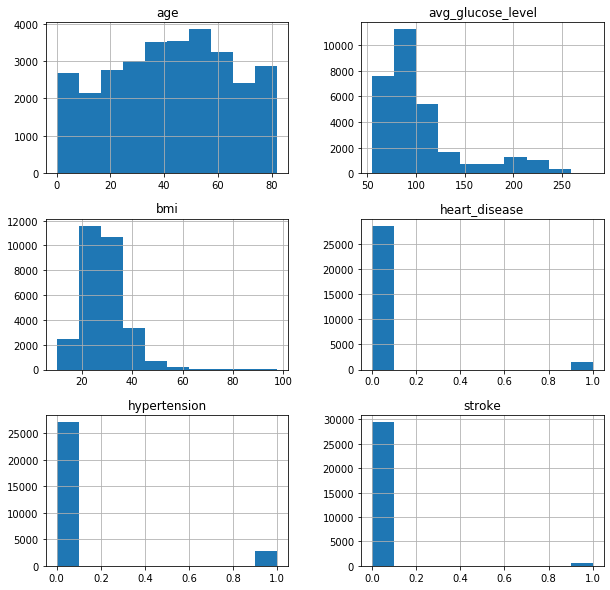

In [5]:
train[numeric_cols + ['stroke']].hist(figsize=(10,10))

In [6]:
train.stroke.value_counts()

0    29471
1      530
Name: stroke, dtype: int64

As we see number of people who had stroke or hypertension or heart_disease is very low. Let's see if there is any correlation.

In [7]:
num_corr = train[numeric_cols + ['stroke']].corr()['stroke'][:-1]
print(num_corr)

age                  0.152684
hypertension         0.073425
heart_disease        0.101548
avg_glucose_level    0.087426
bmi                  0.020317
Name: stroke, dtype: float64


Correlations are low, but that also could be  because of class disbalance. Let's check it.

In [8]:
from sklearn.utils import resample
no_stroke = train[train.stroke == 0]
has_stroke = train[train.stroke == 1]
# Downsamle and upsample of our data
minority_upsampled = resample(has_stroke, replace=True, n_samples=29470, random_state=123)
majority_downsampled = resample(no_stroke, replace=False, n_samples=530, random_state=123)
train_downsampled = pd.concat([majority_downsampled, has_stroke])
train_upsampled = pd.concat([minority_upsampled, no_stroke])
num_corr = train_upsampled[numeric_cols + ['stroke']].corr()['stroke'][:-1]
print(num_corr) 

age                  0.583844
hypertension         0.212633
heart_disease        0.241805
avg_glucose_level    0.262031
bmi                  0.086804
Name: stroke, dtype: float64


Correlation is higher with down and upsampling, especially with age. But again, it is not that high. Another thing that could be noticed is distributions of glucose and bmi have a lot of outliers ('long tail') 

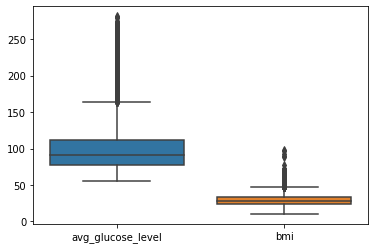

In [9]:
sns.boxplot(data = train[['avg_glucose_level', 'bmi']])

But this two features logically could be very important for the model. So deleting outliers may be a bad idea

/home/dmelikhova/user_venv/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/dmelikhova/user_venv/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


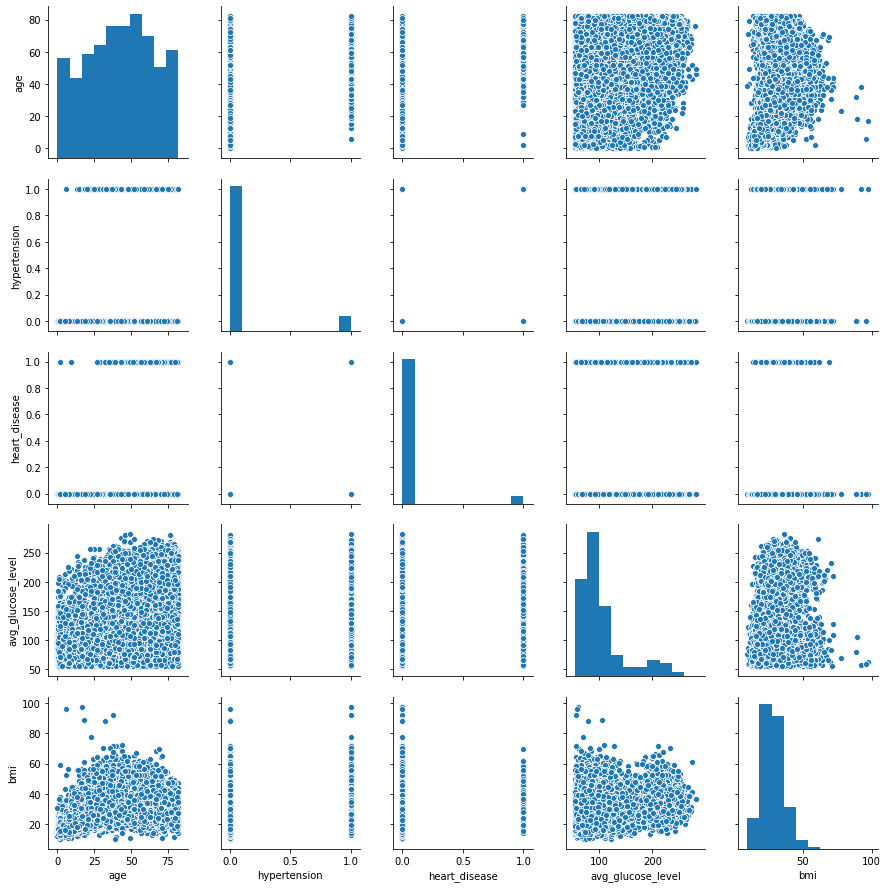

In [10]:
# make scatter plots of features to notice how outliers effect them
sns.pairplot(train[numeric_cols])

But what about cathegorical data. We could make for example box plot. 

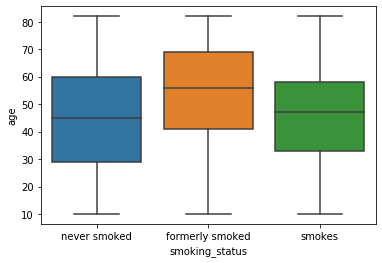

In [11]:
sns.boxplot(x = 'smoking_status', y='age', data=train)

Formerly smoked are slightly older then others.

### Working and selecting features

In [7]:
#get rid of nan in numerical data
for col in numeric_cols:
    train[col] = train[col].fillna(train[col].mean())
    test[col] = test[col].fillna(test[col].mean())

In [8]:
# 'get rid' of nan in categorical data
for col in cat_cols:
    train[col] = train[col].fillna('nan')
    test[col] = test[col].fillna('nan')

On plotes with bmi and glucose we could see outliers lie far away from the cloud of dots.

In [9]:
from scipy import stats
z = np.abs(stats.zscore(train[['avg_glucose_level','bmi']]))
train = train[(z < 3).all(axis=1)]
train.stroke.value_counts()

0    28774
1      504
Name: stroke, dtype: int64

The sympliest one is to work with binomial data.

In [10]:
ever_married_dict = {'No' : 0, 'Yes' : 1}

train['ever_married'] = train['ever_married'].replace(ever_married_dict)
test['ever_married'] = test['ever_married'].replace(ever_married_dict)

In [11]:
Residence_type_dict = {'Rural' : 0, 'Urban' : 1}

train['Residence_type'] = train['Residence_type'].replace(Residence_type_dict)
test['Residence_type'] = test['Residence_type'].replace(Residence_type_dict)

In [12]:
print(train.gender.value_counts())
print(test.gender.value_counts())

Female    17237
Male      12031
Other        10
Name: gender, dtype: int64
Female    7989
Male      5410
Other        1
Name: gender, dtype: int64


In [13]:
# number of others very low, we could put them in one of two classes
gender_dict = {'Other' : 0, 'Male' : 0, 'Female' : 1}

train['gender'] =train['gender'].replace(gender_dict)
test['gender'] = test['gender'].replace(gender_dict)

There are 2 more categorical feature: work and smoker status. 

In [14]:
import category_encoders as ce
#trying target encoding
cat_cols_rest = ['smoking_status', 'work_type']
target_enc = ce.TargetEncoder(cols=cat_cols_rest, smoothing=10)
target_enc.fit(train[cat_cols_rest], train['stroke'])
train_target = train.join(target_enc.transform(train[cat_cols_rest]).add_suffix('_target'))
test_target = test.join(target_enc.transform(test[cat_cols_rest]).add_suffix('_target'))
train_target.drop(['smoking_status', 'work_type', 'id'], axis=1, inplace=True)
test_target.drop(['smoking_status', 'work_type', 'id'], axis=1, inplace=True)

In [15]:
# one hot encoding
test['stroke'] = None
test['train'] = 0
train['train'] = 1
combined = pd.concat([train, test])
df = pd.get_dummies(combined[list(set(cat_cols) - set(['ever_married', 'Residence_type', 'gender']))])
combined = pd.concat([combined, df], axis = 1)
train_dum = combined[combined['train'] == 1]
test_dum = combined[combined['train'] == 0]
train_dum.drop(['train', 'id'] + cat_cols_rest, axis=1, inplace=True)
test_dum.drop(['train', 'stroke', 'id'] + cat_cols_rest, axis=1, inplace=True)

/home/dmelikhova/user_venv/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


I won't try label encoding, because there is no graduate data (maybe smoking status could be graduate but there is some difficulties with formerly smoked and smoking)

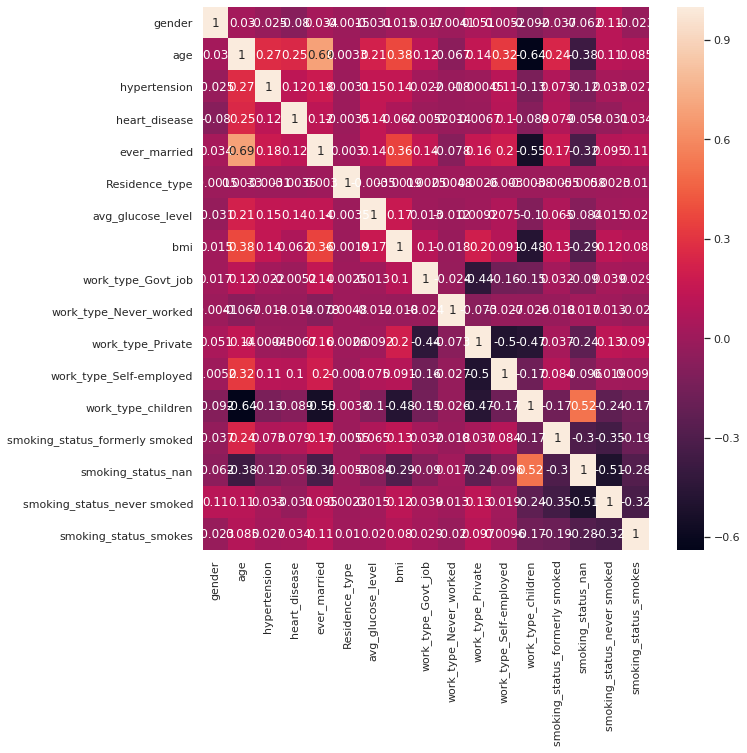

In [16]:
sns.set(rc={'figure.figsize':(10,10)})
sns.heatmap(train_dum.drop(['stroke'], axis=1).corr(), annot=True)

Here we could drop ever_married and work_type_children

In [17]:
train_dum.drop(['work_type_children', 'ever_married'], axis=1, inplace=True)
test_dum.drop(['work_type_children', 'ever_married'], axis=1, inplace=True)

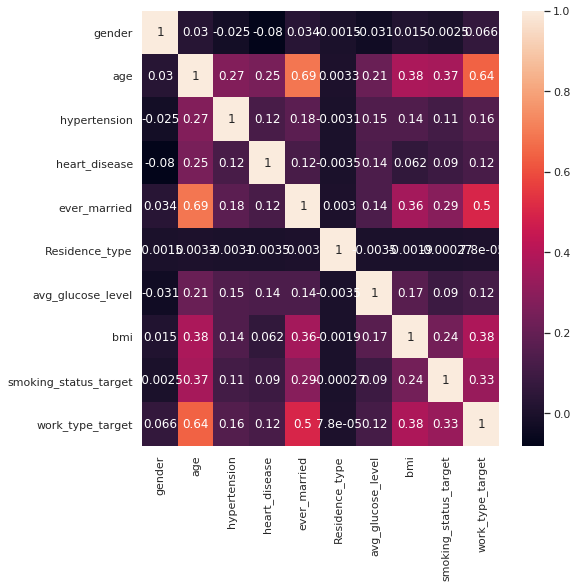

In [18]:
sns.set(rc={'figure.figsize':(8,8)})
sns.heatmap(train_target.drop([ 'stroke'], axis=1).corr(), annot=True)

In [19]:
train_target.drop(['ever_married'], axis=1, inplace=True)
test_target.drop(['ever_married'], axis=1, inplace=True)

### Algorithms of classification

#### Logistic regression

Let's try vanilla logreg, for two types of encoding

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

In [26]:
log = LogisticRegression(solver='liblinear')
print(cross_val_score(log, train_dum.drop('stroke', axis = 1), train_dum.stroke.astype(int), scoring='roc_auc', cv=5).mean())
print(cross_val_score(log, train_target.drop('stroke', axis = 1), train_target.stroke.astype(int), scoring='roc_auc', cv=5).mean())

0.846633900965438
0.8469877246155196


Target encoding got slightly better results, we will work with it

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV

grid_param = {'penalty' : ['l1', 'l2'], 
              'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
              'class_weight' : ['balanced', None], 
              'tol': [0.0005, 0.005, 0.001, 0.01], 
              'max_iter': [100, 500, 1000, 2000]}
grid_clf = GridSearchCV(estimator=LogisticRegression(solver = 'liblinear'), 
                        param_grid=grid_param, 
                        cv=5, 
                        scoring='roc_auc', 
                        n_jobs=5, 
                        verbose=2)
grid_clf.fit(train_target.drop('stroke', axis=1), train_target.stroke.astype(int))
print("tuned hypererparameters : ", grid_clf.best_params_)
print("roc_auc :", grid_clf.best_score_)

Fitting 5 folds for each of 448 candidates, totalling 2240 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:    5.7s
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed:   11.9s
[Parallel(n_jobs=5)]: Done 638 tasks      | elapsed:   22.8s
[Parallel(n_jobs=5)]: Done 1003 tasks      | elapsed:   39.1s
[Parallel(n_jobs=5)]: Done 1448 tasks      | elapsed:  1.0min
[Parallel(n_jobs=5)]: Done 1975 tasks      | elapsed:  1.5min
[Parallel(n_jobs=5)]: Done 2240 out of 2240 | elapsed:  1.7min finished


tuned hypererparameters :  {'C': 1, 'class_weight': None, 'max_iter': 500, 'penalty': 'l1', 'tol': 0.005}
roc_auc : 0.847777394794383


In [29]:
log = LogisticRegression(solver='liblinear', **grid_clf.best_params_)
feature_selection = RFECV(log, step=1, min_features_to_select=1, cv=5, verbose=2, scoring= 'roc_auc')
feature_selection.fit(train_target.drop('stroke', axis=1), train_target['stroke'])

Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator wi

RFECV(cv=5,
      estimator=LogisticRegression(C=1000, class_weight=None, dual=False,
                                   fit_intercept=True, intercept_scaling=1,
                                   l1_ratio=None, max_iter=100,
                                   multi_class='warn', n_jobs=None,
                                   penalty='l2', random_state=None,
                                   solver='liblinear', tol=0.001, verbose=0,
                                   warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='roc_auc', step=1,
      verbose=2)

In [30]:
train_df = feature_selection.transform(train_target.drop('stroke', axis=1))
train_df = pd.DataFrame(train_df, index = train_target.index)
test_df = feature_selection.transform(test_target)
test_df = pd.DataFrame(test_df, index = test_target.index)

In [31]:
final = grid_clf.fit(train_df, train_target['stroke']) 
print("tuned hypererparameters : ", final.best_params_)
print("roc_auc :", final.best_score_)

Fitting 5 folds for each of 448 candidates, totalling 2240 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    6.6s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:   13.9s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:   26.2s
[Parallel(n_jobs=4)]: Done 1005 tasks      | elapsed:   45.4s
[Parallel(n_jobs=4)]: Done 1450 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 1977 tasks      | elapsed:  1.7min


tuned hypererparameters :  {'C': 1000, 'class_weight': None, 'max_iter': 100, 'penalty': 'l2', 'tol': 0.001}
roc_auc : 0.8477599062489731


[Parallel(n_jobs=4)]: Done 2240 out of 2240 | elapsed:  2.0min finished


In [1]:
prediction_log = final.predict_proba(test_df)[:,1]
sample['stroke'] = prediction_log
sample.to_csv('log.csv', index = None )

NameError: name 'final' is not defined

Kaggle score:0.86478

### Random forest classifier

In [24]:
from sklearn.ensemble import RandomForestClassifier

In [25]:
rfc = RandomForestClassifier(n_estimators=100)
print(cross_val_score(rfc, train_dum.drop('stroke', axis = 1), train_dum.stroke.astype(int), scoring='roc_auc', cv=5).mean())
print(cross_val_score(rfc, train_target.drop('stroke', axis = 1), train_target.stroke.astype(int), scoring='roc_auc', cv=5).mean())

0.7689616059065703
0.7732331637202373


In [26]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(4, 15, num = 10)]
max_depth.append(None)

grid = {
 'n_estimators': n_estimators,
 'max_features': max_features,
 'max_depth': max_depth
 }
grid_clf = GridSearchCV(estimator=RandomForestClassifier(), 
                        param_grid=grid, 
                        cv=5, 
                        scoring='roc_auc', 
                        n_jobs=5, 
                        verbose=2)
grid_clf.fit(train_target.drop('stroke', axis=1), train_target.stroke.astype(int))
print("tuned hypererparameters : ", grid_clf.best_params_)
print("roc_auc :", grid_clf.best_score_)

Fitting 5 folds for each of 110 candidates, totalling 550 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   18.1s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:  1.7min
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed:  4.8min
[Parallel(n_jobs=5)]: Done 550 out of 550 | elapsed:  8.3min finished


tuned hypererparameters :  {'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 100}
roc_auc : 0.8496125470719138


In [28]:
rfc = RandomForestClassifier(**grid_clf.best_params_)
feature_selection = RFECV(rfc, step=1, min_features_to_select=1, cv=5, verbose=2, scoring= 'roc_auc')
feature_selection.fit(train_target.drop('stroke', axis=1), train_target['stroke'])

Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator wi

RFECV(cv=5,
      estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                       criterion='gini', max_depth=6,
                                       max_features='sqrt', max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=None,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='roc_auc', step=1,
      verbose=2)

In [29]:
train_df = feature_selection.transform(train_target.drop('stroke', axis=1))
train_df = pd.DataFrame(train_df, index = train_target.index)
test_df = feature_selection.transform(test_target)
test_df = pd.DataFrame(test_df, index = test_target.index)

In [30]:
final = grid_clf.fit(train_df, train_target['stroke']) 
print("tuned hypererparameters : ", final.best_params_)
print("roc_auc :", final.best_score_)

Fitting 5 folds for each of 110 candidates, totalling 550 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   20.2s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:  1.9min
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed:  5.3min
[Parallel(n_jobs=5)]: Done 550 out of 550 | elapsed:  9.2min finished


tuned hypererparameters :  {'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 300}
roc_auc : 0.8515613711064492


In [41]:
prediction_log = final.predict_proba(test_df)[:,1]
sample['stroke'] = prediction_log
sample.to_csv('rfc.csv', index = None )

Kaggle : 0.86078

### XGBoost

In [31]:
import xgboost as xgb
 
grid = param_grid = {'min_child_weight': [1, 3, 6, 9], 
                     'learning_rate': [0.05, 0.1, 0.2],
                     'gamma': [0, 0.1, 0.25, 0.4]
}

grid_clf = GridSearchCV(xgb.XGBClassifier(subsample = 0.85, n_estimators = 100, max_depth = 3, reg_alpha = 1), 
                        param_grid=grid, 
                        scoring="roc_auc",  
                        n_jobs=5, cv = 5, verbose = 2)
final = grid_clf.fit(train_target.drop('stroke', axis = 1), train_target['stroke']) 
print(final.best_score_)
print(final.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    8.9s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:   35.4s
[Parallel(n_jobs=5)]: Done 240 out of 240 | elapsed:   54.8s finished


0.8590290920455357
{'gamma': 0.4, 'learning_rate': 0.1, 'min_child_weight': 9}


In [57]:
prediction = final.predict_proba(test_target)[:,1]
sample['stroke'] = prediction
sample.to_csv('xgb.csv', index = None )

For shap I would like to thank Zoya. Great package!

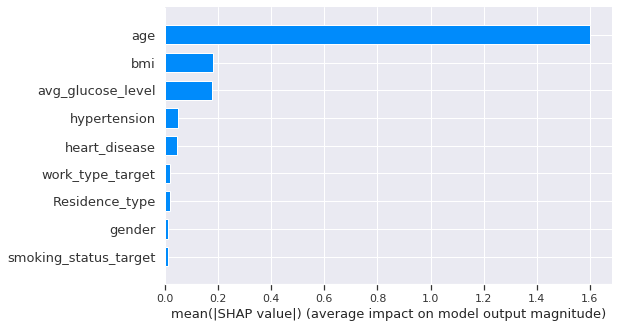

In [32]:
import shap

expl = shap.TreeExplainer(final.best_estimator_)
sh_val = expl.shap_values(train_target.drop('stroke', axis=1))
shap.summary_plot(sh_val, train_target.drop('stroke', axis=1), plot_type = 'bar')

Kaggle score: 0.86078

The most important feature is age. And that is pretty obvious, higher age - higher probability of stroke. 
Such clinical data as glucose_level and bmi also have a very strong effect on health.

The best result on cv was XGBoostClass, but the best result on kaggle LogReg

As for a usage of that model let's see other metrics.

In [34]:
from sklearn.metrics import classification_report, confusion_matrix

In [106]:
print(classification_report(train_target.stroke, 
                            final.predict_proba(train_target.drop('stroke', axis=1))[:, 1]>0.12))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     28774
           1       0.23      0.18      0.20       504

    accuracy                           0.98     29278
   macro avg       0.61      0.58      0.59     29278
weighted avg       0.97      0.98      0.97     29278



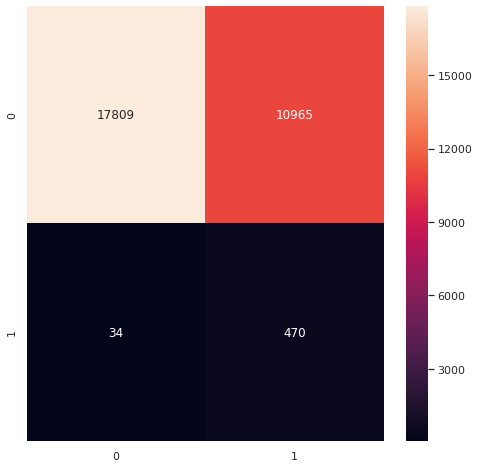

In [108]:
cm = confusion_matrix(train_target.stroke,  
                      final.predict_proba(train_target.drop('stroke', axis=1))[:, 1]>0.1)
cm.ravel()
sns.heatmap(cm, annot=True, fmt='')

Highest precision is ~0.67, but recall at this point is 0, cause TP=2, FP=1, but at this threshold (0.3) the model is poor at finding positive class at all. At threshold of 0.01 we got wonderful recall=0.98, but poor precision, we got a lot of FP.

If we focus on f1, then the best we could get is f1=0.21 and that is quite bad for important class.

For stroke prediction it is important to avoid type 2 error, when we are failing to detect stroke, that is why in our case it is important to raise TP and to lower FN, so the most important metric is recall. But as we notised with high recall comes bad precision, and a lot of people who are healthy will take a treatment (for example).

In my opinion I won't use this model for prediction in real case. Distributions of two classes are highly intesecting and unbalanced.